In [3]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [4]:
#Import data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.shape , test.shape 

((1460, 81), (1459, 80))

In [67]:
#EDA
train.sample(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
684,685,60,RL,58.0,16770,Pave,NaN,IR2,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2010,WD,Normal,221000
194,195,20,RL,60.0,7180,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2008,WD,Normal,127000
182,183,20,RL,60.0,9060,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,6,2007,WD,Normal,120000
1067,1068,60,RL,80.0,9760,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2008,WD,Normal,167900
1006,1007,20,RL,NaN,12155,Pave,NaN,IR3,Lvl,AllPub,...,0,NaN,NaN,NaN,0,3,2007,WD,Normal,163500
1066,1067,60,RL,59.0,7837,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2009,WD,Normal,178000
526,527,20,RL,70.0,13300,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2007,WD,Normal,132000
1224,1225,60,RL,60.0,15384,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,184000
724,725,20,RL,86.0,13286,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2009,WD,Normal,320000
951,952,20,RH,60.0,7800,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,7,2006,WD,Abnorml,119900


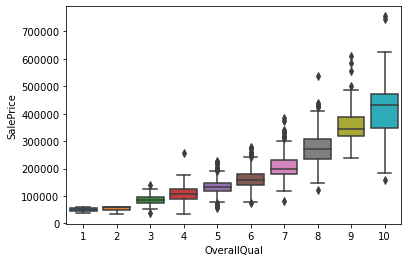

In [68]:
#Examine Overall Quality
ax = sns.boxplot(x="OverallQual", y="SalePrice", data=train)

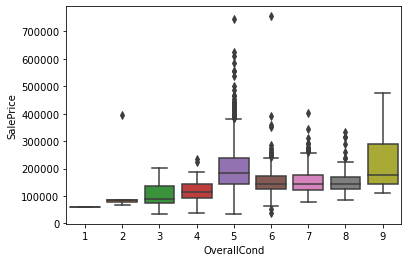

In [69]:
# Overall Condition
ax = sns.boxplot(x="OverallCond", y="SalePrice", data=train)

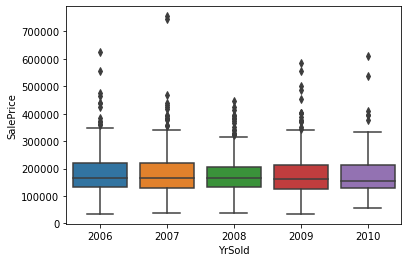

In [70]:
#Year Sold
ax = sns.boxplot(x="YrSold", y="SalePrice", data=train)

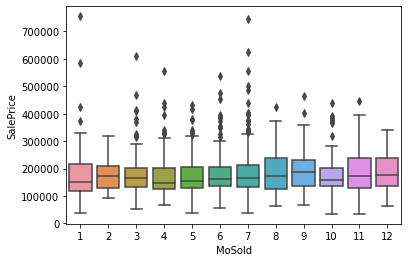

In [71]:
ax = sns.boxplot(x="MoSold", y="SalePrice", data=train)
#It looks like there is very little pricing seasonality

Text(0.5, 1.0, 'Sale Price by Month and Year')

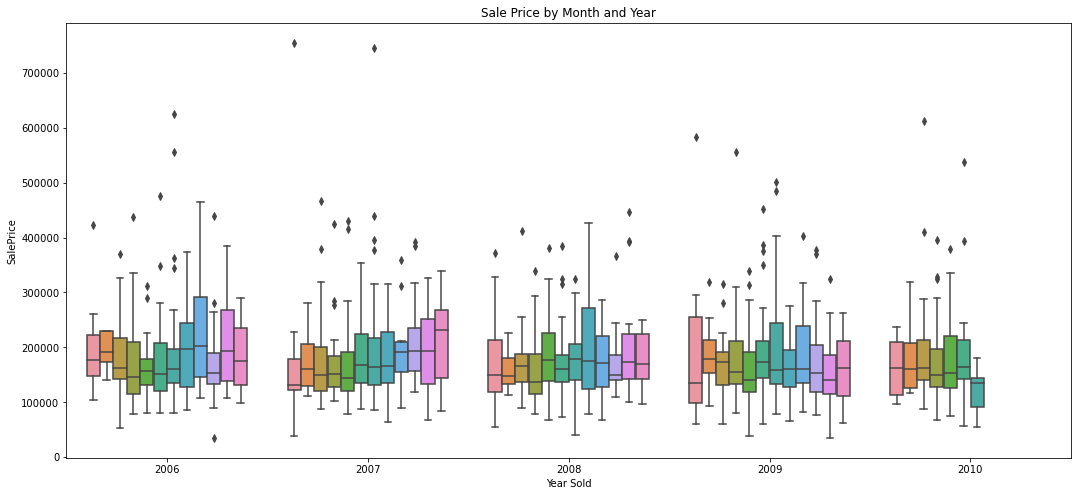

In [72]:
#Month Sold
plt.figure(figsize=(18,8))
ax = sns.boxplot(x="YrSold", y="SalePrice", hue="MoSold", data=train)
ax.legend_.remove()
ax.set_xlabel('Year Sold')
ax.set_title('Sale Price by Month and Year')
#Aside from prices diving in December 2010, there is surprisingly little seasonality in Sale Prices

Text(0.5, 1.0, 'Sale Price of Different Quality Houses by Year')

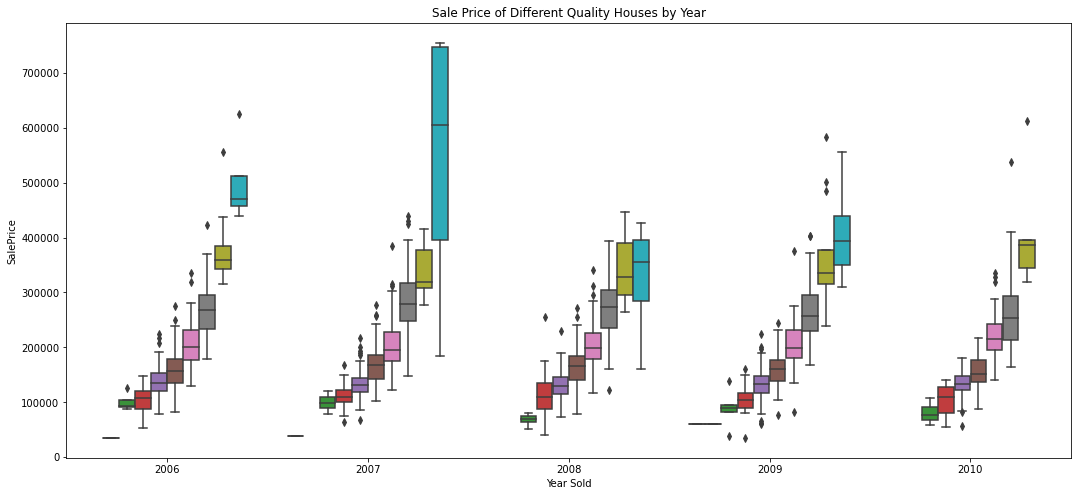

In [73]:
#Did houses of the same quality get priced differently throughout the years?
plt.figure(figsize=(18,8))
ax = sns.boxplot(x="YrSold", y="SalePrice", hue="OverallQual", data=train)
ax.legend_.remove()
ax.set_xlabel('Year Sold')
ax.set_title('Sale Price of Different Quality Houses by Year')

In [6]:
#Save the 'Id' column and remove from train and test sets
train_ID = train['Id']
test_ID = test['Id']

train.drop(['Id'], axis=1, inplace=True)
test.drop(['Id'], axis=1, inplace=True)
train.shape , test.shape

KeyError: 'Id'

Text(0.5, 1.0, 'Features Correlating with Sale Price')

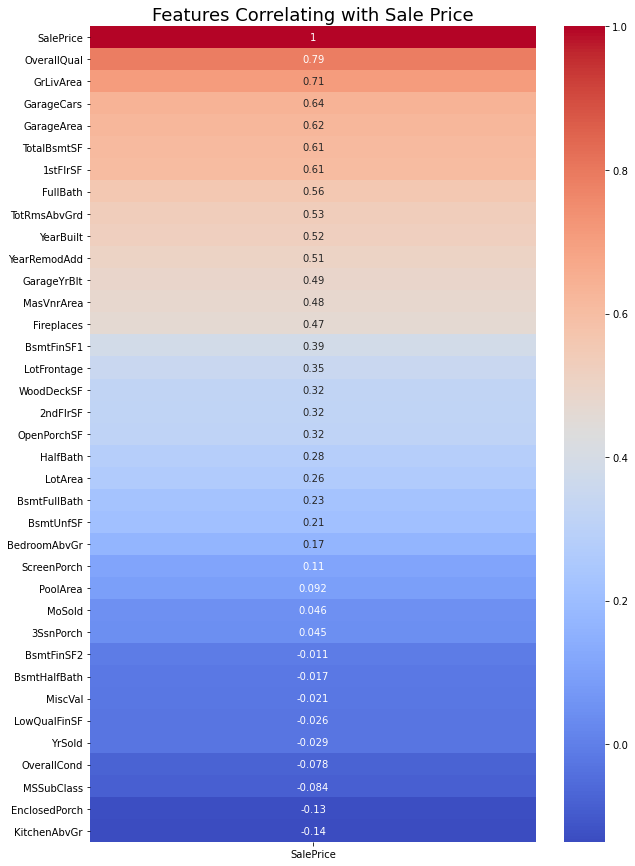

In [75]:
#Heatmap of variables with the highest correlation to sale price
plt.figure(figsize=(10,15))
sns.heatmap(train.corr()[['SalePrice']].sort_values(by='SalePrice', ascending=False),
            annot=True, cmap='coolwarm').set_title('Features Correlating with Sale Price', fontdict={'fontsize':18})

Text(0.5, 1.0, 'Correlation Heatmap')

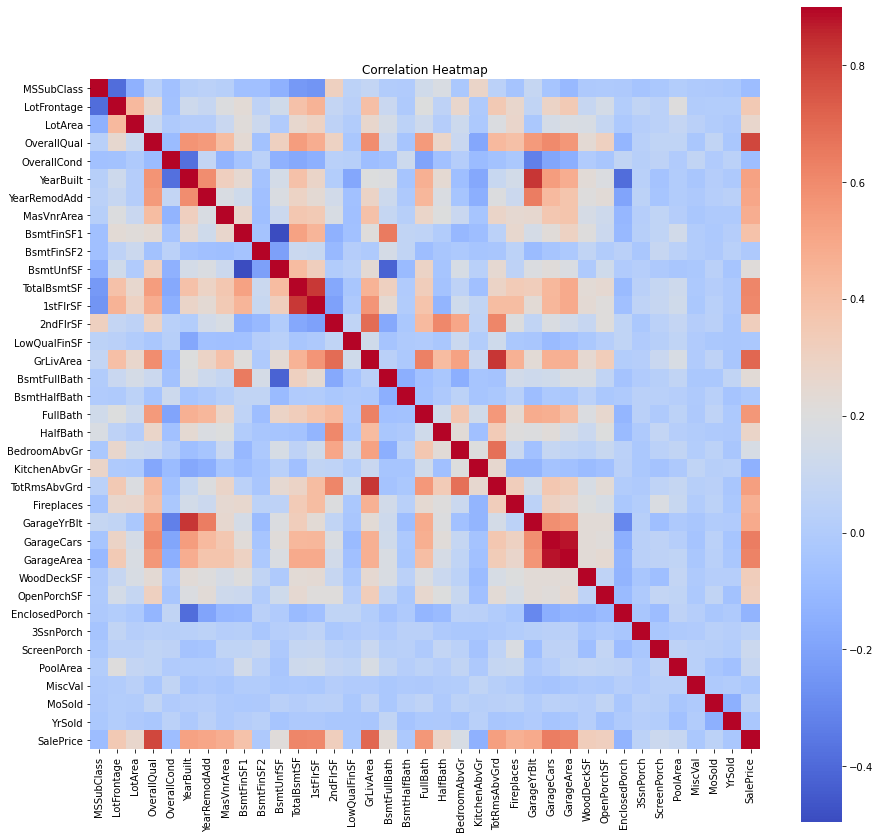

In [76]:
#heatmap to get a sense of correlations
plt.figure(figsize=(15,15))
ax=sns.heatmap(train.corr(), vmax=0.9, square=True, cmap='coolwarm')
ax.set_title('Correlation Heatmap')

- GarageCars seems perfectly correlated with GarageArea, so we can drop GarageCars
- YearBuilt is highly correlated with GarageYrBuilt, which is also correlated with YearRemodAdd, so we can drop GarageYrBuilt
- GrLivArea is highly correlated with TotRmsAbvGrd, we can drop TotRmsAbvGrd
- TotalBsmtSF is highly correlated with 1stFlSF, and since we have this variable we can drop BsmtUnfSF, BsmtFinSF1, BsmtFinSF2
- BsmtFinSF1 is correlated with BsmtFullBath
- We will also drop 1stFlrSF & 2ndFlrSF since this will be expressed in GrLivArea

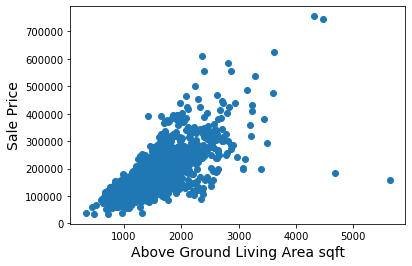

In [77]:
#Data Cleaning

#Plot sale price against GrLivArea
fig, ax = plt.subplots()
ax.scatter(x=train['GrLivArea'], y=train['SalePrice'])
plt.ylabel('Sale Price', fontsize=14)
plt.xlabel('Above Ground Living Area sqft', fontsize=14)
plt.show()

In [ ]:
#Deleting outliers
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<250000)].index)
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('Sale Price', fontsize=14)
plt.xlabel('Above Ground Living Area (sq ft)', fontsize=14)
plt.show()

Text(0.5, 1.0, 'Sale Price Distribution')

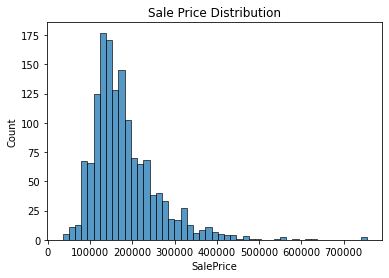

In [79]:
#Plot sale price
sns.histplot(train['SalePrice']).set_title('Sale Price Distribution')

#The plot shows a right skew- we will apply a log transformation to normalize the distribution

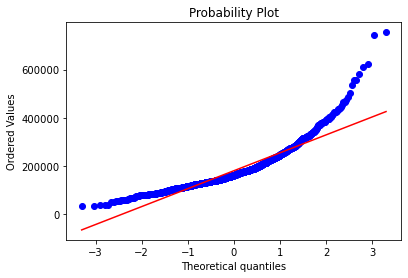

In [80]:
#QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

In [ ]:
#Apply log transformation to sale price
train["SalePrice"] = np.log1p(train["SalePrice"])

#Check the new distribution 
ax=sns.histplot(train['SalePrice'])
plt.title('Log Sale Price Distribution')
ax.set(xlabel="Log SalePrice")

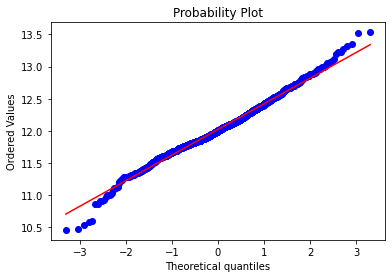

In [82]:
#QQ-plot after log transformation
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

In [8]:
#Create a combined dataset
combined = pd.concat([train,test], axis=0, sort=False)
combined.drop(['SalePrice'], axis=1, inplace=True)

#Drop redundant/unnecessary columns
combined = combined.drop(columns=['GarageCars','GarageYrBlt','TotRmsAbvGrd','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF',
                                 '1stFlrSF','2ndFlrSF'])
combined.shape

(2919, 71)

In [9]:
#Missing values
combined_na = (combined.isnull().sum() / len(combined)).sort_values(ascending=False)

na_ratios = pd.DataFrame({'Ratio of Missing Values' :combined_na})

#Show all columns that contain missing values
na_ratios[na_ratios['Ratio of Missing Values']>0]

,Ratio of Missing Values
PoolQC,0.996574
MiscFeature,0.964029
Alley,0.932169
Fence,0.804385
FireplaceQu,0.486468
LotFrontage,0.166495
GarageCond,0.054471
GarageFinish,0.054471
GarageQual,0.054471
GarageType,0.053786


In [10]:
#Fill NAs as "None" where appropriate based on documentation
none_cols = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 
            'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
            'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
             'MasVnrType']

combined[none_cols] = combined[none_cols].fillna('None')

#Fill zeros for numerical NAs
zero_cols = ['GarageArea','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath','MasVnrArea']

combined[zero_cols]=combined[zero_cols].fillna(0)

In [11]:
#Lot Frontage: does this correlate to Lot Area? It the correlation is high, we will drop LotFrontage
from scipy.stats import pearsonr
lot_compare = combined[combined['LotFrontage'].notna()]

corr, _ = pearsonr(lot_compare['LotFrontage'], lot_compare['LotArea'])
print('Pearsons correlation of lot area and lot frontage: %.3f' % corr)

Pearsons correlation of lot area and lot frontage: 0.469


In [11]:
#Impute median neighhborhood LotFrontage instead of dropping it
combined['LotFrontage'] = combined.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))
#Check for remaining LotFrontage missingness
combined['LotFrontage'].isnull().sum()

0

In [12]:
#Impute mode for categorical missing values
combined['MSZoning'] = combined['MSZoning'].fillna(combined['MSZoning'].mode()[0])
combined['Electrical'] = combined['Electrical'].fillna(combined['Electrical'].mode()[0])
combined['KitchenQual'] = combined['KitchenQual'].fillna(combined['KitchenQual'].mode()[0])
combined['Exterior1st'] = combined['Exterior1st'].fillna(combined['Exterior1st'].mode()[0])
combined['Exterior2nd'] = combined['Exterior2nd'].fillna(combined['Exterior2nd'].mode()[0])
combined['SaleType'] = combined['SaleType'].fillna(combined['SaleType'].mode()[0])
combined['Functional'] = combined['Functional'].fillna(combined['Functional'].mode()[0])

In [13]:
#Utilities
combined['Utilities'].value_counts()
train['Utilities'].value_counts()
#All values are the same except for one from the train set, so we will drop this variable
combined = combined.drop(['Utilities'], axis=1)

#Check for remaining missingness
combined.isnull().sum().sum()

0

In [14]:
#Converting numeric variables that are actually categorical

#Converting MSSubClass and Month Sold
combined['MSSubClass']=combined['MSSubClass'].astype("str")
combined['MoSold']=combined['MoSold'].astype("str")

combined.MSSubClass.dtype

dtype('O')

In [15]:
#Feature Engineering

#house age
combined['HouseAge']= combined['YrSold']-combined['YearBuilt']

#years since remodel
combined['YrsSinceRemod']= combined['YrSold']-combined['YearRemodAdd']

#total bathrooms
combined['Bathrooms']= combined['FullBath']+(combined['HalfBath']*.5)+combined['BsmtFullBath']+(combined['BsmtHalfBath']*.5)

#total porch sq ft
combined['PorchSF']= combined['OpenPorchSF']+combined['EnclosedPorch']+combined['3SsnPorch']+combined['ScreenPorch']

In [16]:
#Drop columns used in calculating new columns
combined = combined.drop(columns=['FullBath','HalfBath','BsmtFullBath','BsmtHalfBath',
                                 'OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch',
                                 'YearBuilt','YearRemodAdd'])

#Convert YrSold to Category
combined['YrSold']=combined['YrSold'].astype("str")

In [17]:
#Identify variables with high skew levels
skewed = combined.skew(axis=0).sort_values(ascending=False)

high_skew = skewed[skewed > 0.5]
high_skew

MiscVal         21.958480
PoolArea        16.907017
LotArea         12.829025
LowQualFinSF    12.094977
KitchenAbvGr     4.304467
MasVnrArea       2.614936
PorchSF          2.238417
WoodDeckSF       1.843380
LotFrontage      1.506478
MSSubClass       1.376165
GrLivArea        1.270010
TotalBsmtSF      1.157489
Fireplaces       0.733872
HouseAge         0.598917
OverallCond      0.570605
dtype: float64

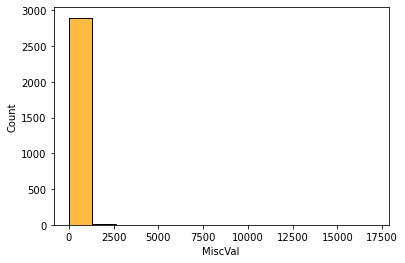

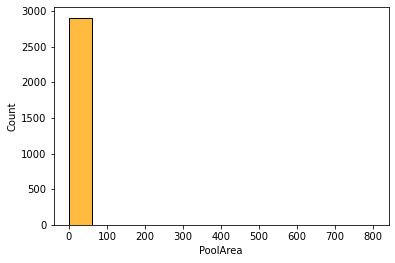

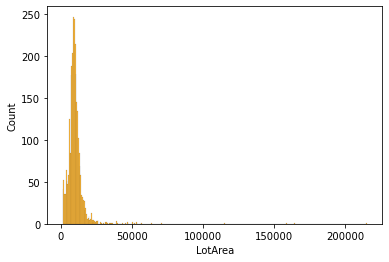

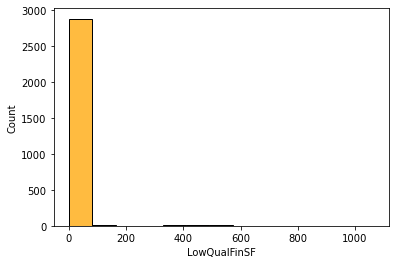

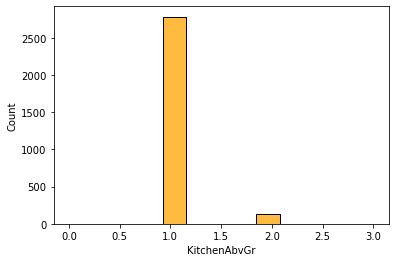

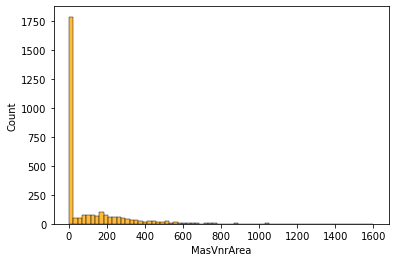

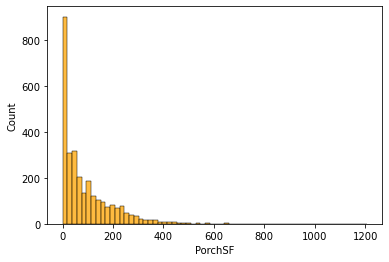

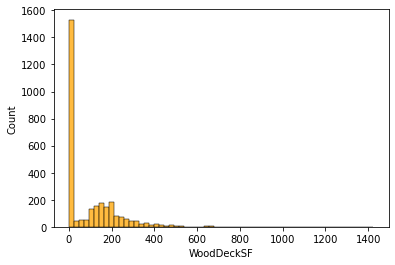

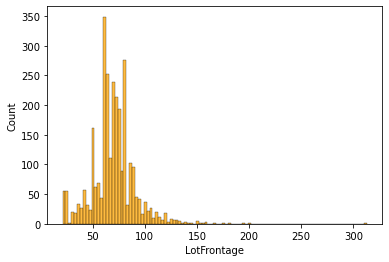

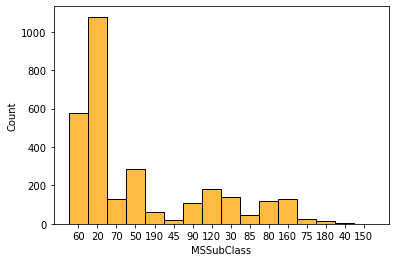

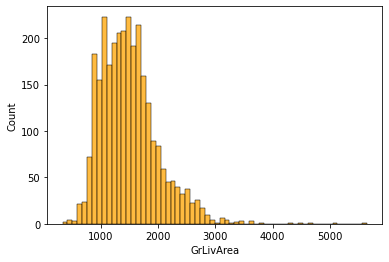

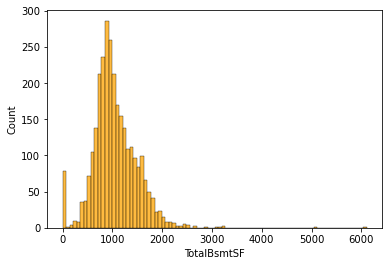

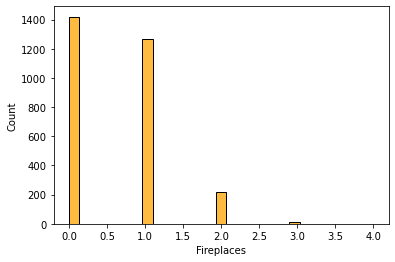

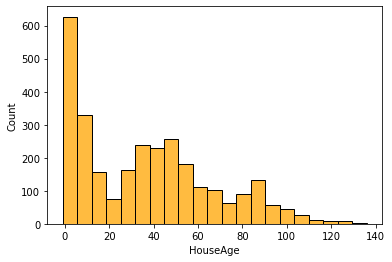

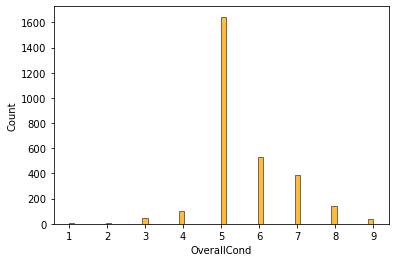

In [19]:
#
skew_plt = list(high_skew.index)
for i in skew_plt:    
    fig, ax=plt.subplots()
    sns.histplot(combined[i], color='orange')

In [19]:
#drop LowQualFinSF(vast majority of values are zero), PoolArea(this is somewhat redundant with PoolQuality)
combined = combined.drop(columns=['LowQualFinSF','PoolArea'])
#re-run skew
skewed = combined.skew(axis=0).sort_values(ascending=False)
high_skew = skewed[skewed > 0.5]
high_skew

MiscVal         21.950962
LotArea         13.116240
KitchenAbvGr     4.302763
MasVnrArea       2.623068
PorchSF          2.245655
WoodDeckSF       1.845741
MSSubClass       1.375838
LotFrontage      1.103606
GrLivArea        1.069300
Fireplaces       0.725651
TotalBsmtSF      0.672097
HouseAge         0.598323
OverallCond      0.569607
dtype: float64

/Users/emilywang/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


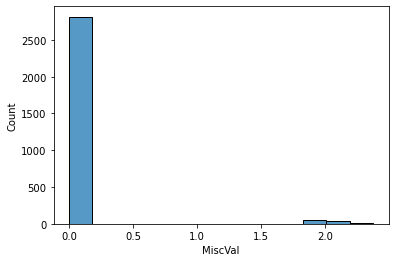

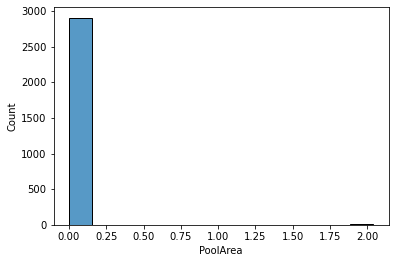

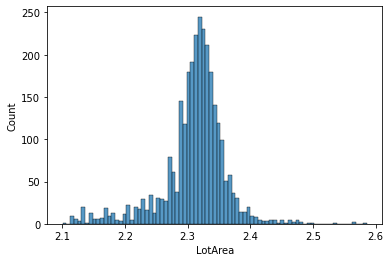

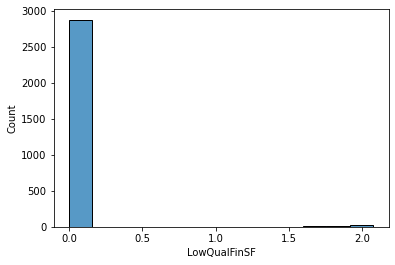

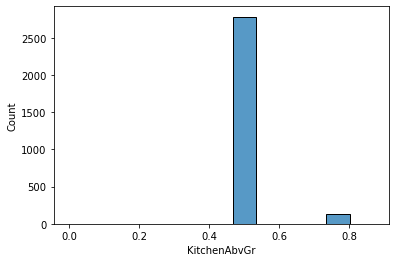

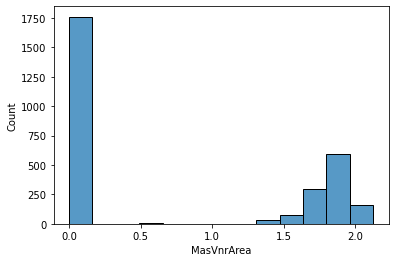

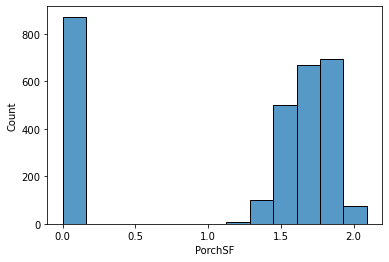

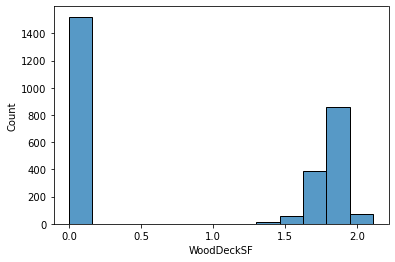

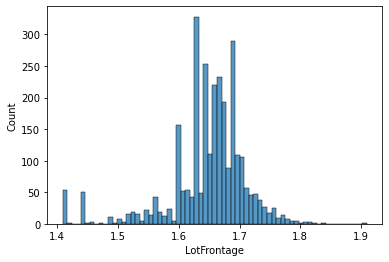

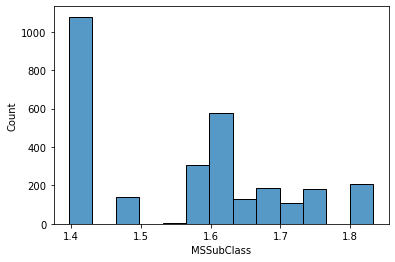

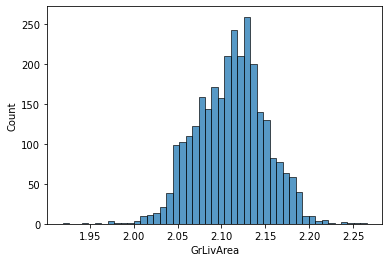

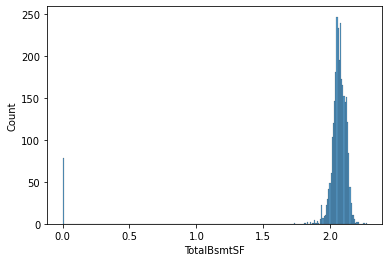

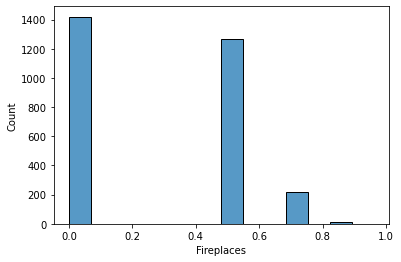

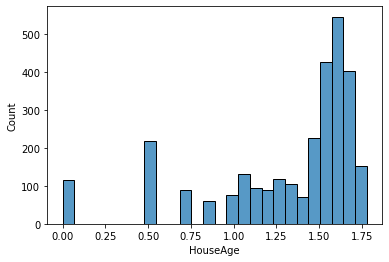

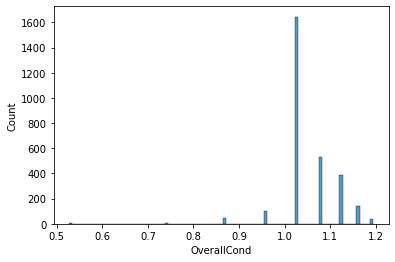

In [21]:
#Log transformation of skewed numerical features
for feat in high_skew.index:
    combined[feat] = np.log1p(combined[feat].astype('float'))

skew_plt = list(high_skew.index)    
for i in skew_plt:    
    fig, ax=plt.subplots()
    sns.histplot(combined[i])

In [21]:
# Mapping some ordinal categorical variables that contain information in their ordering set to integers for linear models
quality = {'Ex' : 5, 'Gd' : 4, 'TA' : 3, 'Fa' : 2, 'Po' : 1, 'None' : 0}

combined = combined.replace({
    'ExterQual':quality, 'ExterCond':quality,
    'BsmtQual':quality, 'BsmtCond':quality,
    'BsmtExposure':{'Gd':4, 'Av':3, 'Mn':2, 'No':1 , 'None':0},
    #Basement average rec room coded equivalent to average living quarters
    'BsmtFinType1':{'GLQ':5, 'ALQ':4, 'BLQ':3, 'Rec':4, 'LwQ':2, 'Unf':1, 'None':0},
    'BsmtFinType2':{'GLQ':5, 'ALQ':4, 'BLQ':3, 'Rec':4, 'LwQ':2, 'Unf':1, 'None':0},
    'HeatingQC': quality, 'CentralAir': {'No':0, 'Yes':1},
    'KitchenQual': quality,
    'Functional':{'Typ':7, 'Min1':6, 'Min2':5, 'Mod':4, 'Maj1':3, 'Maj2':2, 'Sev':1, 'Sal':0},
    'FireplaceQu' : quality,
    'GarageFinish':{'Fin':3, 'RFn':2, 'Unf':1, 'None':0},
    'GarageQual' :quality, 'GarageCond' :quality,
    'PavedDrive' :{'Y':2, 'P':1, 'N':0},
    'PoolQC' : quality,
})
combined.shape

(2917, 62)

In [22]:
#Dummify remaining categorical variables (non-ordinal)
combined2 = combined.copy()
combined2 = pd.get_dummies(combined)
combined2.shape

(2917, 231)

In [23]:
#Re-split data into train and test
y = train['SalePrice']

x_train = combined2[:len(y)]
x_test = combined2[len(y):]

x_train_cat = combined[:len(y)]
x_test_cat = combined[len(y):]

x_train_cat.shape, x_test_cat.shape

((1458, 62), (1459, 62))

In [24]:
#Split train data for training model

x_train, x_test, y_train, y_test = train_test_split(x_train, y, test_size=.30, random_state=0)
x_train_cat, x_test_cat, y_train, y_test = train_test_split(x_train_cat, y, test_size=.30, random_state=0)

In [25]:
# RMSE error measure

scorer = make_scorer(mean_squared_error, greater_is_better = False)

def rmse_cv_train(model):
    rmse= np.sqrt(-cross_val_score(model, x_train, y_train, scoring = scorer, cv = 10))
    return(rmse)

def rmse_cv_test(model):
    rmse= np.sqrt(-cross_val_score(model, x_test, y_test, scoring = scorer, cv = 10))
    return(rmse)

In [26]:
#Fit linear regression
lr = LinearRegression()
lr.fit(x_train, y_train)

print("R^2 for train set: %f" %lr.score(x_train, y_train))
print("R^2 for test set: %f" %lr.score(x_test, y_test))

print("RMSE on Training set :", rmse_cv_train(lr).mean())
print("RMSE on Test set :", rmse_cv_test(lr).mean())

R^2 for train set: 0.942984
R^2 for test set: 0.911304
RMSE on Training set : 6795138.09650364
RMSE on Test set : 0.17441238872943346


In [27]:
#Ridge Regression
ridge = RidgeCV(alphas = [0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 30, 60])
ridge.fit(x_train, y_train)
alpha = ridge.alpha_
print("Initial alpha :", alpha)
#Tuned further
ridge = RidgeCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, alpha * .85, 
                          alpha * .9, alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15,
                          alpha * 1.25, alpha * 1.3, alpha * 1.35, alpha * 1.4], 
                cv = 10)
ridge.fit(x_train, y_train)
alpha = ridge.alpha_
print("Best alpha :", alpha)

print("Ridge RMSE on Training set :", rmse_cv_train(ridge).mean())
print("Ridge RMSE on Test set :", rmse_cv_test(ridge).mean())

Initial alpha : 6.0
Best alpha : 4.5
Ridge RMSE on Training set : 0.11931078541341922
Ridge RMSE on Test set : 0.12853450059910937


Ridge picked 225 features and eliminated the other 6 features


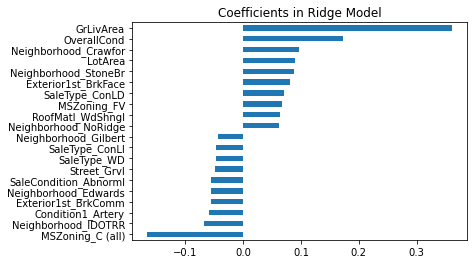

In [28]:
# Plot Ridge important coefficients
coefs = pd.Series(ridge.coef_, index = x_train.columns)
print("Ridge picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in Ridge Model")
plt.show()

In [29]:
#Lasso Regression
lasso = LassoCV(alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 
                          0.3, 0.6, 1], 
                max_iter = 50000, cv = 10)
lasso.fit(x_train, y_train)
alpha = lasso.alpha_
print("Initial alpha :", alpha)

lasso = LassoCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, 
                          alpha * .85, alpha * .9, alpha * .95, alpha, alpha * 1.05, 
                          alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3, alpha * 1.35, 
                          alpha * 1.4], 
                max_iter = 50000, cv = 10)
lasso.fit(x_train, y_train)
alpha = lasso.alpha_
print("Best alpha :", alpha)

print("Lasso RMSE on Training set :", rmse_cv_train(lasso).mean())
print("Lasso RMSE on Test set :", rmse_cv_test(lasso).mean())

Initial alpha : 0.0006
Best alpha : 0.00047999999999999996
Lasso RMSE on Training set : 0.11738615528802525
Lasso RMSE on Test set : 0.1198578010199681


Lasso picked 100 features and eliminated the other 131 features


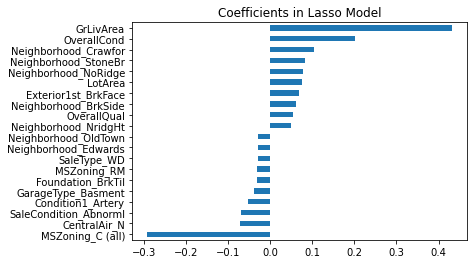

In [30]:
# Plot Lasso important coefficients
coefs = pd.Series(lasso.coef_, index = x_train.columns)
print("Lasso picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in Lasso Model")
plt.show()

In [31]:
dt=DecisionTreeRegressor(random_state=100)
dt.fit(x_train,y_train)

print("The training accuracy is: %.5f" % (dt.score(x_train, y_train)))
print("The test     accuracy is: %.5f" % (dt.score(x_test, y_test)))

print(f"Random Forest RMSE on Training set: {rmse_cv_train(dt).mean()}")
print(f"Random Forest RMSE on Testing set: {rmse_cv_test(dt).mean()}")

The training accuracy is: 1.00000
The test     accuracy is: 0.70512
Random Forest RMSE on Training set: 0.23520629150244637
Random Forest RMSE on Testing set: 0.2018080425305088


In [119]:
from sklearn import ensemble

rf = ensemble.RandomForestRegressor()
rf.set_params(random_state=0)

rf.fit(x_train, y_train)

print("The training accuracy is: %.5f" % (rf.score(x_train, y_train)))
print("The test     accuracy is: %.5f" % (rf.score(x_test, y_test)))

print(f"Random Forest RMSE on Training set: {rmse_cv_train(rf).mean()}")
print(f"Random Forest RMSE on Testing set: {rmse_cv_test(rf).mean()}")

The training accuracy is: 0.98085
The test     accuracy is: 0.89784
Random Forest RMSE on Training set: 0.1436900280366136
Random Forest RMSE on Testing set: 0.14286997381954666


In [129]:
gb = GradientBoostingRegressor()
gb.fit(x_train, y_train)

print("The training accuracy is: %.5f" % (gb.score(x_train, y_train)))
print("The test     accuracy is: %.5f" % (gb.score(x_test, y_test)))

print(f"Random Forest RMSE on Training set: {rmse_cv_train(gb).mean()}")
print(f"Random Forest RMSE on Testing set: {rmse_cv_test(gb).mean()}")

The training accuracy is: 0.96679
The test     accuracy is: 0.91496
Random Forest RMSE on Training set: 0.12806107649390136
Random Forest RMSE on Testing set: 0.13432297666288823


In [36]:
import xgboost as xgb
xgb = xgb.XGBRegressor()
xgb.fit(x_train, y_train)
rmse_cv_train(xgb)
print(f"XG Boosting Regression RMSE on Training set:{rmse_cv_train(xgb).mean()}")
print(f"XG Boosting Regression RMSE on Testing set:{rmse_cv_test(xgb).mean()}")

XG Boosting Regression RMSE on Training set:0.13836226263545054
XG Boosting Regression RMSE on Testing set:0.14149137351644897
